## Sentiment-Based Model Creation

In the following notebook, a second model is created on the corpus; this one utilizes vaderSentiment scores for every data point in the corpus. This model was conceptualized with the intention of creating a combined model afterwards; it has one primary benefit over the bERT-BiLSTM model in that it handles simpler, shorter text imputs better.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
corpus = pd.read_csv('../data/corpus.csv',index_col='Unnamed: 0')
corpus = corpus[corpus['subreddit']!='Anxiety']

In [4]:
X = corpus[['neg', 'neu', 'pos', 'comp']]
y = corpus['subreddit'].map({'depression':1,'CasualConversation':0,'happy':0})

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
model_s = Sequential()

model_s.add(Input(shape=(X_train.shape[1],)))
model_s.add(Dense(64,activation='relu'))
model_s.add(Dropout(0.5))
model_s.add(Dense(64,activation='relu'))
model_s.add(Dropout(0.5))
model_s.add(Dense(32,activation='relu'))

model_s.add(Dense(1,activation='sigmoid'))

#Architechture might be too simple here, make it (a bit) more robust and see if accuracy improves
#Also go back and set things up so sample for this sentiment-based test is the same as the bERT test and compare.

In [7]:
model_s.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history_s = model_s.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200, verbose=0)

In [9]:
np.mean(history_s.history['val_accuracy'])

0.7770899984240532

In [11]:
model_s.save('../data/model_s.hd')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../data/model_s.hd\assets


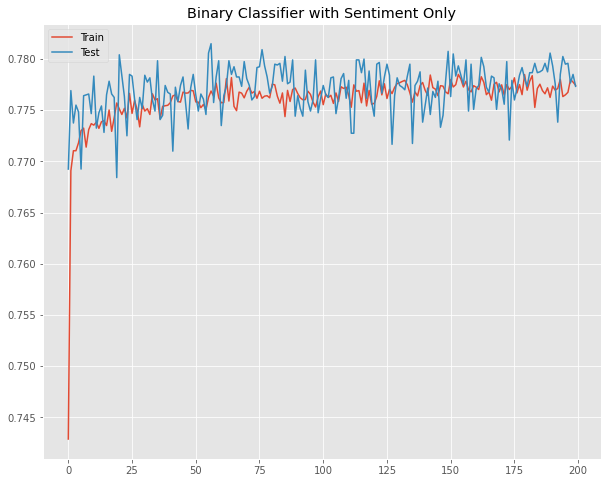

In [10]:
plt.figure(figsize=(10,8))
plt.plot(history_s.history['accuracy'], label='Train')
plt.plot(history_s.history['val_accuracy'], label='Test')
plt.title('Binary Classifier with Sentiment Only')
plt.legend()

#### Model Evaluation

In [9]:
corpus = pd.read_csv('../data/corpus.csv',index_col='Unnamed: 0')
corpus = corpus[corpus['subreddit']!='Anxiety']

In [10]:
X = corpus[['neg', 'neu', 'pos', 'comp']]
y = corpus['subreddit'].map({'depression':1,'CasualConversation':0,'happy':0})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
model_sr = load_model('../data/model_s.hd/')

In [14]:
preds = model_sr.predict_classes(X_test)
preds = preds.reshape(1,-1).ravel()
preds

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 1, ..., 1, 1, 1])

In [16]:
y_test = y_test.to_numpy()

In [17]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [18]:
cm = confusion_matrix(y_test,preds)
cm

array([[4578, 1331],
       [1341, 4750]], dtype=int64)

Text(69.0, 0.5, 'True')

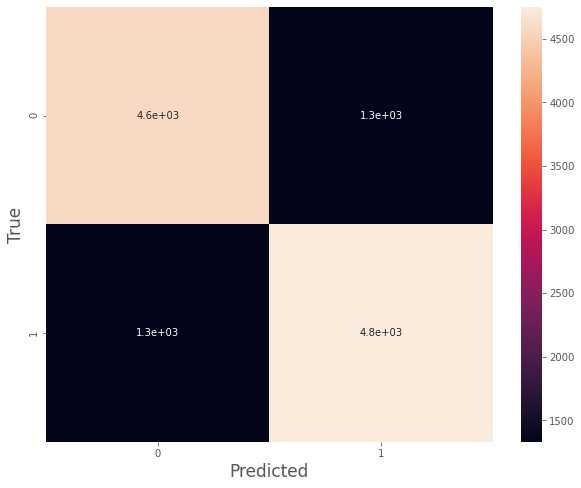

In [19]:
plt.figure(figsize=(10,8))
g = sns.heatmap(cm, annot=True); #annot=True to annotate cells
g.set_xlabel("Predicted",size=17)
g.set_ylabel("True",size=17)

# X-axis is predicted labels
# y-axis is true labels

In [20]:
tn, fp, fn, tp = cm.ravel()

In [21]:
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [22]:
clf_dict = {'recall':recall,'specificity':specificity,'precision':precision,'accuracy':accuracy,'F1':f1_score}

In [23]:
clf_df = pd.DataFrame(clf_dict,index=['Scores']).T
clf_df

,Scores
recall,0.779839
specificity,0.774750
precision,0.781122
accuracy,0.777333
F1,0.780480
